### 编码器和解码器架构
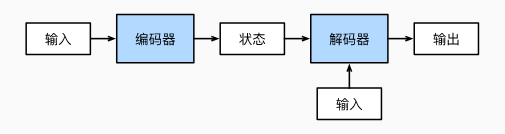

In [1]:
# 编码器
from torch import nn

# 构建编码器的基类
class Encoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def forward(self, X, *args):
        raise NotImplementedError

In [2]:
# 解码器
class Decoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def init_state(self, enc_outputs, *args):
        raise NotImplementedError
        
    def forward(self, X, state):
        raise NotImplementedError

In [42]:
# 合并编码器和解码器
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

### 序列到序列学习（seq2seq）
使用循环神经网络编码器和循环神经网络解码器的序列到序列学习
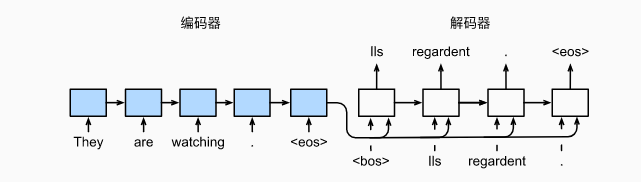
编码器：
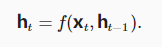
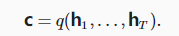
解码器：
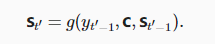

编码器-解码器
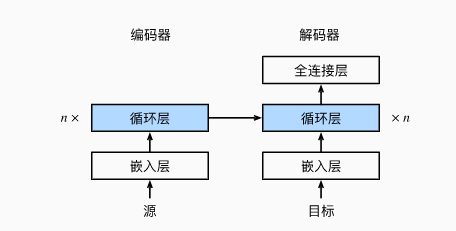



In [4]:
import collections
import math
import torch
import dltools

In [5]:
# seq2seq encoder
class Seq2SeqEncoder(Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super().__init__(**kwargs)
        
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)
        
    def forward(self, X, *args):
        # 注意X的形状. 在进行embedding之前, X的形状是多少? 一般都是(batch_size, num_steps, vocab_size)
        # X经过embedding处理, X的形状: (batch_size, num_steps, embed_size)
        X = self.embedding(X)
        #  根据文档说明, 默认是: (num_steps, batch_size, embed_size), 所以要调换一下维度. 
        X = X.permute(1, 0, 2)
        
        # 没有手动传入state, 这时, pytorch会帮我们完成隐藏状态的初始化, 即0. 
        output, state = self.rnn(X)
        # output的形状: (num_steps, batch_size, num_hiddens)
        # state[0]的形状: (num_layers, batch_size, num_hiddens)
        return output, state

In [6]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.eval()
# batch_size=4, num_steps=7
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)

In [7]:
output.shape

torch.Size([7, 4, 16])

In [8]:
len(state)

2

In [9]:
state.shape

torch.Size([2, 4, 16])

In [10]:
state[0].shape

torch.Size([4, 16])

In [11]:
class Seq2SeqDecoder(Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        # 输出层
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]
    
    def forward(self, X, state):
        # X经过embedding处理, X的形状: (batch_size, num_steps, embed_size)
        X = self.embedding(X)
        # 调整维度顺序
        X = X.permute(1, 0, 2)
        
        # 把X和state拼接到一起. 方便计算. 
        # X现在的形状(num_steps, batch_size, embed_size) 最后一层state的形状(batch_size, num_hiddens)
        # 要把state的形状扩充成三维. 变成(num_steps, batch_size, embed_size)
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output的形状: (batch_size, num_steps, vocab_size)
        # state的形状: (num_layers, batch_size, num_hiddens)
        return output, state

In [12]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

In [ ]:
# seq2seq的训练: pytorch中训练代码, 都是一个套路. 

In [32]:
def sequence_mask(X, valid_len, value=0):
    # 找到最大序列长度
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None] < valid_len[:, None]
#     print(mask)
    X[~mask] = value
    return X

In [22]:
torch.arange((3))[None, :] < torch.tensor([1, 1])[:, None]

tensor([[0, 1, 2]])

In [23]:
torch.tensor([1, 1])[:, None]

tensor([[1],
        [1]])

In [24]:
torch.tensor([1, 1]).reshape(2, 1)

tensor([[1],
        [1]])

In [19]:
import numpy as np

In [20]:
np.arange(3)

array([0, 1, 2])

In [26]:
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
X.size(1)

3

In [29]:
sequence_mask(X, torch.tensor([1, 1]))

tensor([[ True, False, False],
        [ True, False, False]])


tensor([[1, 0, 0],
        [4, 0, 0]])

In [30]:
X = torch.ones(2, 3, 4)
X

tensor([[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]])

In [31]:
sequence_mask(X, torch.tensor([2, 2]), value=-1)

tensor([[ True,  True, False],
        [ True,  True, False]])


tensor([[[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

In [35]:
# 重写交叉熵损失, 添加屏蔽无效内容的部分. 
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    # 重写forward
    # pred的形状: (batch_size, num_steps, vocab_size)
    # label的形状: (batch_size, num_steps)
    # valid_len的形状: (batch_size, )
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        # 先调用原始的交叉熵损失, 就可以计算没有被mask的损失. 
        self.reduction = 'none'
        unweighted_loss = super().forward(pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [36]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long), torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

In [40]:
# 训练
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    # 初始化
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if 'weight' in param:
                    nn.init.xavier_uniform_(m._parameters[param])
                    
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    animator = dltools.Animator(xlabel='epoch', ylabel='loss', xlim=[10, num_epochs])
    
    for epoch in range(num_epochs):
        timer = dltools.Timer()
        metric = dltools.Accumulator(2) # 统计训练的总损失, 词元数量
        for batch in data_iter:
            # 梯度清零
            optimizer.zero_grad()
            # 取数据
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1, 1)
            # 开头加上了bos, 那么Y就要去掉最后一列, 保证序列的长度不变. 
            dec_input = torch.cat([bos, Y[:, :-1]], 1)
            Y_hat, _ = net(X, dec_input, X_valid_len)
            # 计算损失
            l = loss(Y_hat, Y, Y_valid_len)
            # 反向传播
            l.sum().backward()
            # 梯度裁剪
            dltools.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            # 更新
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
                
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0]/ metric[1]))
    print(f'loss {metric[0]/metric[1]:.3f}, {metric[1] / timer.stop():.1f}', f'tokens/sec on {str(device)}')

loss 0.018, 16437.4 tokens/sec on cuda:0


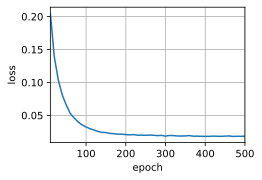

In [47]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 500, dltools.try_gpu()

train_iter, src_vocab, tgt_vocab = dltools.load_data_nmt(batch_size, num_steps)

encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)

decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)

net = EncoderDecoder(encoder, decoder)

train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [44]:
# 预测和评估
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps, device):
    # 预测的时候需要把net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = dltools.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    
    # 增加一个维度用来表示批次. 
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    
    # 给预测结果也提前加一个批次维度. 
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    
    output_seq = []
    for _ in range(num_steps):
        Y,dec_state = net.decoder(dec_X, dec_state)
        dec_X = Y.argmax(dim=2)
        
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq))

### bleu定义
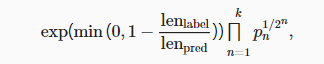
label:  A、B、C、D、E、F
predict:A、B、B、C、D

In [ ]:
power

In [ ]:
math.pow(x, y) -> x ** y

In [45]:
# seq2seq的评估指标: BLEU: bilingual evaluation understudy 双语互译质量评估辅助工具
def bleu(pred_seq, label_seq, k):
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - (len_label / len_pred)))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
            
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *=  math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))   
    return score

In [48]:
# 开始预测
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation = predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu <unk> ., bleu 0.658
he's calm . => il est paresseux est paresseux . ai vous en <unk>, bleu 0.316
i'm home . => je suis suis <unk> ., bleu 0.548
